In [39]:
import pickle
from math import floor
from IPython.display import display, clear_output
import scipy.stats
from pylab import * 
from collections import OrderedDict
import numpy as np
import seaborn as sns
import pandas
from itertools import product as iterproduct, groupby, chain
%matplotlib inline
%run "/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/lib/analysis_lib.ipynb"
sns.set_style("ticks", {"axes.grid" : True, "grid.color" : ".95"})
matplotlib.rcParams.update({'font.size': 16})

In [40]:
# args = {
#     "true_events": "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/david_alignment_true_events.pickle",
#     "ref": "/home/ibis/gregor.sturm/nanopore/david_eccles_bc_ideas/mouse_ref.fa",
# }

# args = {
#     "true_events": "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/lambda_alignment.62pA_true_events.pickle",
#      "ref": "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/lambda_ref.fasta",
# #     "ref": "/home/sturm/Downloads/lambda_ref.fasta"
# }

args = {
    "true_events": "/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/loman006-1_5000.alignment_true_events.pickle",
     "ref": "/home/ibis/gregor.sturm/nanopore/NanoporeData/PublicData/LomanLab_MAP-006/ecoli_mg1655.fa",
#     "ref": "/home/sturm/Downloads/lambda_ref.fasta"
}

In [41]:
NMER = 6
CONTEXT = 100
MEAN = 59

In [42]:
!pwd

/home/ibis/gregor.sturm/nanopore/own/notebooks


In [43]:
true_events = pickle.load(open(args["true_events"], 'rb'))

In [44]:
ref = load_ref(args["ref"])

['>gi|556503834|ref|NC_000913.3| Escherichia coli str. K-12 substr. MG1655, complete genome']
AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATTAAAAAAAGAGTGTCTGATAGCAGCTTCTGAACTGGTTACCTGCCGTGAGTAAAT


In [45]:
def _get_context(event, start, end):
    """get the nt-context around the kmer. 
    E.g. start=-20: get context 20nt before the reference point
    (mid of kmer)"""
    ref_pos = event["ref_position"]
    start = ref_pos + start
    end = ref_pos + end
    context = ref[start:end]
    
    if len(context) != end-start:
        print(start, end, len(ref), len(context), end-start)
        raise IndexError
    else: return context

def get_context_before(event, n):
    """get n nucleotides before the start of the kmer"""
    length = len(event["kmer"])
    offset = 0
    return _get_context(event, -n+offset, offset)
    
def get_context_after(event, n):
    length = len(event["kmer"])
    offset = length
    return _get_context(event, offset, offset+n)

In [46]:
test_event = true_events[2000]
print(test_event['kmer'], _get_context(test_event, 0,6))
assert test_event['kmer'] == _get_context(test_event, 0, 6), "invalid reference"
assert (get_context_before(test_event, 20) 
        + test_event['kmer'] 
        + get_context_after(test_event, 20)) == (
    _get_context(test_event, -20, 26))

GGCAGT GGCAGT


## Analysis 

In [47]:
all_kmers = mk_kmer_dict(NMER)
ev_map = mk_event_map(true_events, all_kmers)

In [48]:
def prepare_events(kmer):
    template_events = [ev for ev in ev_map[kmer] if not np.isnan(ev["mean"])]
    template_events = [ev for ev in template_events if 
                   ev["ref_position"] > CONTEXT+NMER+1 and ev["ref_position"] < len(ref)-CONTEXT-NMER-1]
    print("kmer {0}".format(kmer))
    print(">>genomic_positions {0}".format(len(set([ev["ref_position"] for ev in template_events]))))
    print(">>total_events {0}".format(len(template_events)))
    return template_events

In [49]:
template_events = [prepare_events(kmer) for kmer in all_kmers]

kmer AAAAAA
>>genomic_positions 1016
>>total_events 2514
kmer AAAAAC
>>genomic_positions 1160
>>total_events 2021
kmer AAAAAG
>>genomic_positions 846
>>total_events 1238
kmer AAAAAT
>>genomic_positions 1146
>>total_events 1657
kmer AAAACA
>>genomic_positions 880
>>total_events 1491
kmer AAAACC
>>genomic_positions 1172
>>total_events 2146
kmer AAAACG
>>genomic_positions 1092
>>total_events 1938
kmer AAAACT
>>genomic_positions 852
>>total_events 1556
kmer AAAAGA
>>genomic_positions 429
>>total_events 591
kmer AAAAGC
>>genomic_positions 859
>>total_events 1350
kmer AAAAGG
>>genomic_positions 338
>>total_events 518
kmer AAAAGT
>>genomic_positions 511
>>total_events 761
kmer AAAATA
>>genomic_positions 1076
>>total_events 1827
kmer AAAATC
>>genomic_positions 1299
>>total_events 2291
kmer AAAATG
>>genomic_positions 1279
>>total_events 2330
kmer AAAATT
>>genomic_positions 1043
>>total_events 1966
kmer AAACAA
>>genomic_positions 631
>>total_events 1046
kmer AAACAC
>>genomic_positions 536
>>tota

In [50]:
context = (-20, 26)
context_buckets = [{nt: [] for nt in NTS} for _ in range(*context)]

In [51]:
for kmer_evs in template_events: 
    for ev in kmer_evs:
        nt_context = _get_context(ev, *context)
        for i, pos in enumerate(range(*context)): 
            context_buckets[i][nt_context[i]].append(ev["mean"])


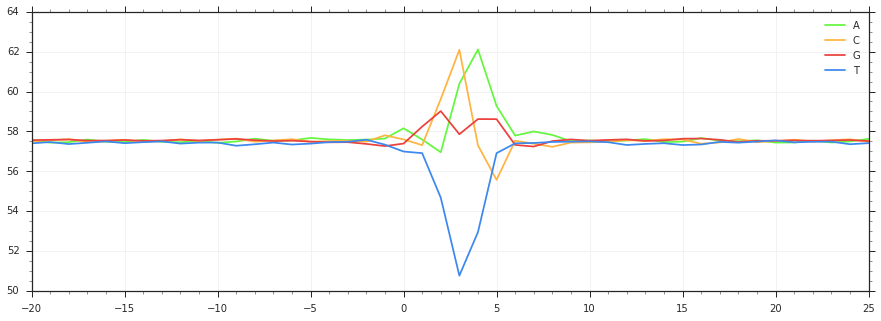

In [52]:
fig, ax = subplots(figsize=(15, 5))
for nt in NTS:
    ax.plot(range(*context), [mean(pos[nt]) for pos in context_buckets], color=NT_COLORS[nt], label=nt)
ax.legend()
ax.minorticks_on()